# Facility Location Problem (P-median)

Consider the optimization problem where you have a set of $M$ customers and a set of $N$ potential locations for opening a facility. Given transportation costs between facilities and customers and the number of facilities you would like to open ($P$), determine which facilities to open such that the total transportation cost between facilities and customers is minimal, under the constraint that each customer is allocated to only one facility.

Possible extensions:

- Add a different demand for each customer.
- Add the cost for opening a facility at each location.
- Consider different categories of facilities and that customers can have multiple allocations for different facilities.

## Mathematical Modeling

The input of the model is a set of $M$ customers $\{1,\dots,M\}$, a set of $N$ potential locations for facilities $\{1,\dots,N\}$, an $N\times M$ matrix $d$ where $d_{nm}$ is the cost of customer $m$ buying from facility $n$, and the total number of facilities we want to open is $P$.

Define a binary variable for the optimization problem: an $N\times M$ matrix $x$ such that $x_{nm}=1$ if the customer $m$ is allocated to facility $n$.

The objective function to minimize is the total cost function:
$$
\min_{x} \sum_{n,m} d_{nm}x_{nm}
$$
Constraints:

(1) Each customer is supplied: $\forall m\in[0,M] \,\,\, \sum_n x_{nm}=1$.

(2) Total number of open facilities is $P$: $\sum_n\Pi_m (1-x_{nm})=N-P$ (the inner product is zero if the $n-$th facility is not open).

### Alternative Modeling
There is an alternative modeling for adding another variable to the model: a binary vector $y$ of size $N$, which indicates which facilities are open. In this formulation the second constraint can be written as $\sum_n y_n=P$ together with an inequality constraint $\forall n,m:\, x_{nm} \leq y_n$. A model that combines equality and inequality constraints may become available in the future.

Note that this alternative modeling has a quadratic unconstrained binary optimization (QUBO) problem (compared to the formulation above where constraint (2) is a polynomial of degree $m$). However, the alternative modeling has more variables to minimize on, and thus refers to more qubits.

### Example

If you can open facilities in Japan, USA, and France, and you have four customers whose costs for buying from these three locations are given. To open in total $P=2$ facilities, the optimization problem is to find where to open the facilities and which customer is allocated to which facility.

Draw this specific example on a graph. There are $N=3$ locations and $M=4$ customers, where the weights of the edges between them signify the costs:

Suggestions:
- Give a general problem description and then givens, or provide givens after each mention.
- Standardize writing numbers appearing in sentences when less than 10: "4" vs. "four".

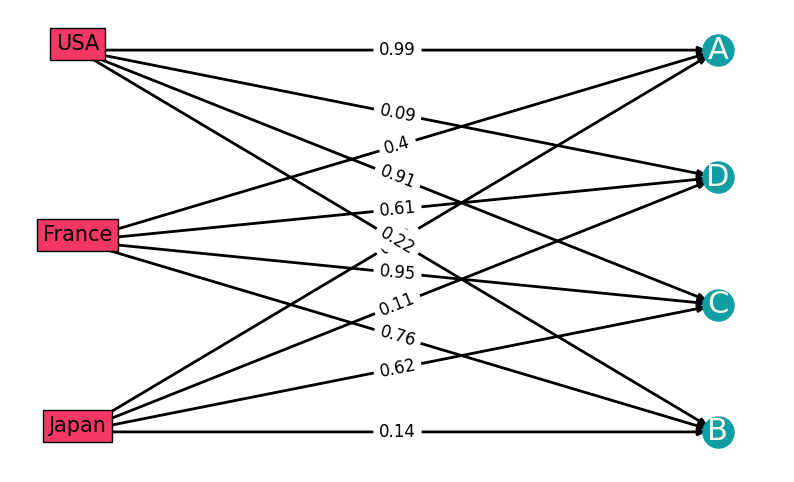

In [5]:
# Import relevant packages

from itertools import product

import matplotlib.pyplot as plt
import networkx as nx  # noqa
import numpy as np
import pandas as pd

# Declare givens from problem statement

Facilities = ["Japan", "USA", "France"]
Customers = ["A", "B", "C", "D"]

N = len(Facilities)  # potential facility count
M = len(Customers)  # customer count
P = 2  # allocated facility count

# costs of customers using facilities
d = np.array(
    [[0.02, 0.14, 0.62, 0.11], [0.99, 0.22, 0.91, 0.09], [0.4, 0.76, 0.95, 0.61]]
)


graph = nx.DiGraph()
graph.add_nodes_from(Facilities + Customers)
for n, m in product(range(N), range(M)):
    graph.add_edges_from([(Facilities[n], Customers[m])], weight=d[n, m])


# Plot the graph
plt.figure(figsize=(10, 6))
left = nx.bipartite.sets(graph)[0]
pos = nx.bipartite_layout(graph, left)

nx.draw_networkx(graph, pos=pos, nodelist=Customers, font_size=22, font_color="None")
nx.draw_networkx_nodes(
    graph, pos, nodelist=Customers, node_color="#119DA4", node_size=500
)
for fa in Facilities:
    x, y = pos[fa]
    plt.text(
        x,
        y,
        s=fa,
        bbox=dict(facecolor="#F43764", alpha=1),
        horizontalalignment="center",
        fontsize=15,
    )

nx.draw_networkx_edges(graph, pos, width=2)
labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_size=12)
nx.draw_networkx_labels(
    graph,
    pos,
    labels={co: co for co in Customers},
    font_size=22,
    font_color="#F4F9E9",
)

plt.axis("off")
plt.show()

## Building the Pyomo Model from a Matrix of Distances

In [6]:
from typing import List, Tuple, cast  # noqa

import pyomo.environ as pyo
from IPython.display import Markdown, display

In [7]:
## Define a function that gets a matrix of costs between customers and potential facilities
## and the number of facilities to open.


def pmedian(cost_mat: np.ndarray, P: int) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("pmedian")

    N = cost_mat.shape[0]  # potential facility amount
    M = cost_mat.shape[1]  # customer count
    Locations = range(N)
    Customers = range(M)

    model.x = pyo.Var(Locations, Customers, domain=pyo.Binary)

    @model.Constraint(Customers)
    def each_customer_is_supplied_rule(model, m):  # constraint (1)
        return sum(model.x[n, m] for n in Locations) == 1

    def is_location_alocated(n):  # constraint (2)
        return np.prod([(1 - model.x[n, m]) for m in Customers])

    model.num_facilities = pyo.Constraint(
        expr=sum(is_location_alocated(n) for n in Locations) == N - P
    )

    model.cost = pyo.Objective(
        expr=sum(cost_mat[n, m] * model.x[n, m] for n in Locations for m in Customers),
        sense=pyo.minimize,
    )

    return model

### Solving with Classiq

Take the specific example outlined above:

In [8]:
pmedian_model = pmedian(d, P)

To solve the Pyomo model,  use the `CombinatorialProblem` Python class. Under the hood it translates the Pyomo model to a quantum model of the QAOA algorithm [[1](#QAOA)], with the cost Hamiltonian translated from the Pyomo model. Choose the number of layers for the QAOA ansatz using the `num_layers` argument:

In [9]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=pmedian_model, num_layers=5, penalty_factor=10)

qmod = combi.get_model()

In [10]:
write_qmod(qmod, "facility_location")

### Synthesizing the QAOA Circuit and Solving the Problem

Synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [11]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2zJEZtDZDBqSpw793eHKnq7THbP


Now, solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm, define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[2](#cvar)]:

In [12]:
optimized_params = combi.optimize(maxiter=50)

Optimization Progress: 51it [03:35,  4.23s/it]                                                                                                                                                                                                     


Check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

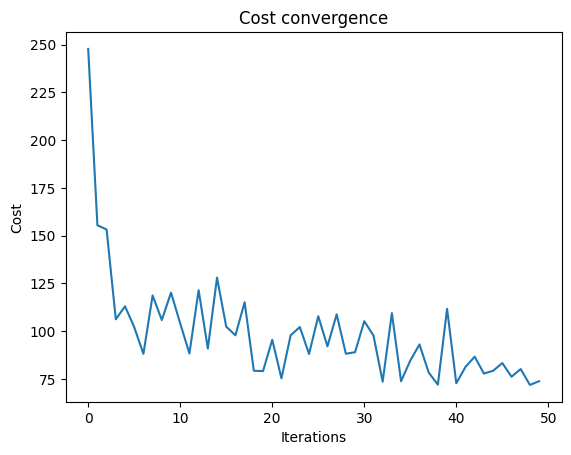

In [13]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

Examine the statistics of the algorithm. To get samples with the optimized parameters, call the `sample` method:

In [14]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
1035,"{'x': [[1, 1, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]]}",0.000488,0.87
756,"{'x': [[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 0, 0]]}",0.000488,0.95
230,"{'x': [[1, 0, 0, 0], [0, 1, 1, 1], [0, 0, 0, 0]]}",0.000977,1.24
766,"{'x': [[0, 1, 1, 1], [0, 0, 0, 0], [1, 0, 0, 0]]}",0.000488,1.27
329,"{'x': [[1, 1, 1, 0], [0, 0, 0, 0], [0, 0, 0, 1]]}",0.000977,1.39


Compare the optimized results to uniformly sampled results:

In [15]:
uniform_result = combi.sample_uniform()

And compare the histograms:

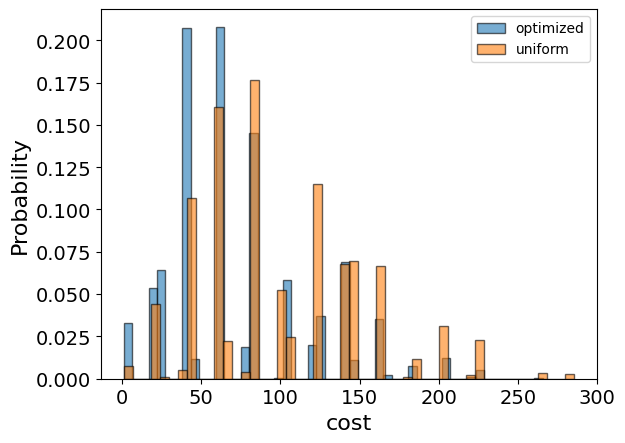

In [16]:
optimization_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=50,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Plot the solution:

In [17]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x': [[1, 1, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]]}

Define a function that plots solutions:

In [18]:
# This function plots the solution in a table and a graph


def plotting_sol(x_sol, cost, is_classic: bool):
    x_sol_to_mat = np.reshape(np.array(x_sol), [N, M])  # vector to matrix
    # opened facilities will be marked in red
    opened_fac_dict = {}
    for fa in range(N):
        if sum(x_sol_to_mat[fa, m] for m in range(M)) > 0:
            opened_fac_dict.update({Facilities[fa]: "background-color: #F43764"})

    # classical or quantum
    if is_classic == True:
        display(Markdown("**CLASSICAL SOLUTION**"))
        print("total cost= ", cost)
    else:
        display(Markdown("**QAOA SOLUTION**"))
        print("total cost= ", cost)

    # plotting in a table
    df = pd.DataFrame(x_sol_to_mat)
    df.columns = Customers
    df.index = Facilities
    plotable = df.style.apply(lambda x: x.index.map(opened_fac_dict))
    display(plotable)

    # plotting in a graph
    graph_sol = nx.DiGraph()
    graph_sol.add_nodes_from(Facilities + Customers)
    for n, m in product(range(N), range(M)):
        if x_sol_to_mat[n, m] > 0:
            graph_sol.add_edges_from([(Facilities[n], Customers[m])], weight=d[n, m])

    plt.figure(figsize=(10, 6))
    left = nx.bipartite.sets(graph_sol, top_nodes=Facilities)[0]
    pos = nx.bipartite_layout(graph_sol, left)

    nx.draw_networkx(
        graph_sol, pos=pos, nodelist=Customers, font_size=22, font_color="None"
    )
    nx.draw_networkx_nodes(
        graph_sol, pos, nodelist=Customers, node_color="#119DA4", node_size=500
    )
    for fa in Facilities:
        x, y = pos[fa]
        if fa in opened_fac_dict.keys():
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F43764", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )
        else:
            plt.text(
                x,
                y,
                s=fa,
                bbox=dict(facecolor="#F4F9E9", alpha=1),
                horizontalalignment="center",
                fontsize=15,
            )

    nx.draw_networkx_edges(graph_sol, pos, width=2)
    labels = nx.get_edge_attributes(graph_sol, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_size=12)
    nx.draw_networkx_labels(
        graph_sol,
        pos,
        labels={co: co for co in Customers},
        font_size=22,
        font_color="#F4F9E9",
    )

    plt.axis("off")
    plt.show()

### Best Solution

Plot the quantum result only if you get the right solution (to avoid problems with printing the table and graph):

In [21]:
best_solution

solution       {'x': [[1, 1, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]]}
probability                                             0.000488
cost                                                        0.87
Name: 1035, dtype: object

**QAOA SOLUTION**

total cost=  0.87


,A,B,C,D
Japan,1,1,1,0
USA,0,0,0,1
France,0,0,0,0


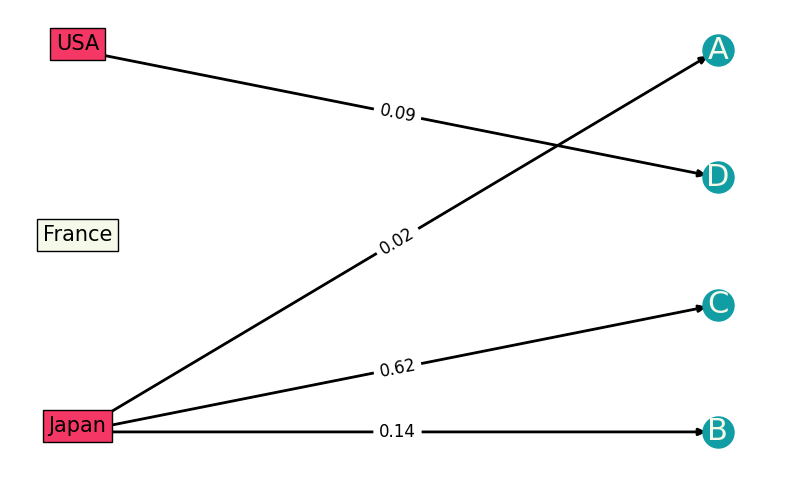

In [23]:
best_solution = optimization_result.loc[optimization_result.cost.idxmin()]

plotting_sol(best_solution.solution["x"], best_solution.cost, is_classic=False)

### Compare to a Classical Solver

In [24]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(pmedian_model)

pmedian_model.display()

Model pmedian

  Variables:
    x : Size=12, Index=x_index
        Key    : Lower : Value                  : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :                    1.0 :     1 : False : False : Binary
        (0, 1) :     0 :                    1.0 :     1 : False : False : Binary
        (0, 2) :     0 :                    1.0 :     1 : False : False : Binary
        (0, 3) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 0) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 1) :     0 :  6.846989283059948e-10 :     1 : False : False : Binary
        (1, 2) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 3) :     0 :                    1.0 :     1 : False : False : Binary
        (2, 0) :     0 :                    0.0 :     1 : False : False : Binary
        (2, 1) :     0 : -6.846989283059948e-10 :     1 : False : False : Binary
        (2, 2) :     0 :                    0.0 : 

**CLASSICAL SOLUTION**

total cost=  0.8699999996302625


,A,B,C,D
Japan,1.000000,1.000000,1.000000,0.000000
USA,0.000000,0.000000,0.000000,1.000000
France,0.000000,-0.000000,0.000000,0.000000


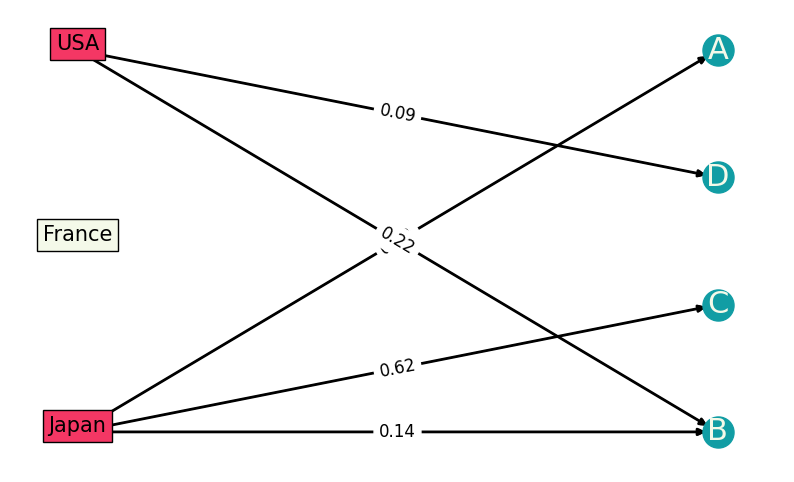

In [25]:
best_classical_solution = np.array(
    [pyo.value(pmedian_model.x[idx]) for idx in np.ndindex(d.shape)]
).reshape(d.shape)

plotting_sol(best_classical_solution, pyo.value(pmedian_model.cost), is_classic=True)